In [57]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from Tokenizer.loaderH5 import H5GuitarTokenizer
from lightning.pytorch.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
from lightning.pytorch.loggers import WandbLogger
from TModel.GuitarTokenEmbeddingModel import GuitarTokenEmbeddingModel
from TUtils import random_string
from TranscriptionDataset import GuitarTokenDataset
from lightning import Trainer
import torch

# torch.set_float32_matmul_precision('medium')

In [2]:
datasetLocation = "Trainsets/TokensOnly_1695456272_mTokens1000_mNoS60.hdf5"
wandbProject = "GuitarEmbeddingModel"
batchSize = 1024
num_workers = 12

In [3]:
dataset,pipe = GuitarTokenDataset.getDataPipe(datasetLocation,11,pinMemory=False)
train_dl = DataLoader(dataset=pipe, batch_size=batchSize,num_workers=num_workers)

In [4]:
model = GuitarTokenEmbeddingModel(vocab_size=dataset.getVocabSize(),cfs=dataset.getCfs())

wandb_logger = WandbLogger(project=wandbProject)
wandb_logger.experiment.config.update(dataset.meta_data)
wandb_logger.experiment.config["batchSize"] = batchSize
checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',
    dirpath=f'Models/GuitarToken/{random_string(10)}/',
    filename='GuitarTokenEmbeddingModel-{epoch:02d}-{train_loss:.2f}',
    every_n_train_steps=200000,
    save_top_k=3,
    mode='min',
)
trainer = Trainer(
    default_root_dir='Models/',
    max_epochs=5,
    # profiler="simple",
    # precision="bf16-mixed",
    logger=wandb_logger,
    callbacks=[checkpoint_callback],
    # max_time="00:00:05:00"
)

trainer.fit(model=model, train_dataloaders=train_dl)

wandb: Currently logged in as: draguve. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | embeddings | Embedding | 4.5 M 
1 | loss       | SGNSLoss  | 4.5 M 
-----------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
18.190    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

C:\Users\ritwi\anaconda3\envs\pytorch\Lib\site-packages\lightning\pytorch\trainer\call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [5]:
trainer.save_checkpoint("Models/GuitarToken/Max10LengthTrained15Min.ckpt")

In [21]:
x = next(train_dl.__iter__())

In [61]:
model_empty = GuitarTokenEmbeddingModel(vocab_size=dataset.getVocabSize(),cfs=dataset.getCfs()).to("cuda")
model = GuitarTokenEmbeddingModel.load_from_checkpoint("Models/GuitarToken/Max2Length.ckpt").to("cuda")

In [63]:
z = x[0].to(model.device)
y = model.embeddings(z)
y_0 = model_empty.embeddings(z)

In [64]:
tsne = TSNE()
embed_tsne = tsne.fit_transform(y.cpu().detach().numpy())
embed_tsne_empty =  tsne.fit_transform(y_0.cpu().detach().numpy())

In [65]:
tokenizer = H5GuitarTokenizer(datasetFile=dataset.datasetFile)

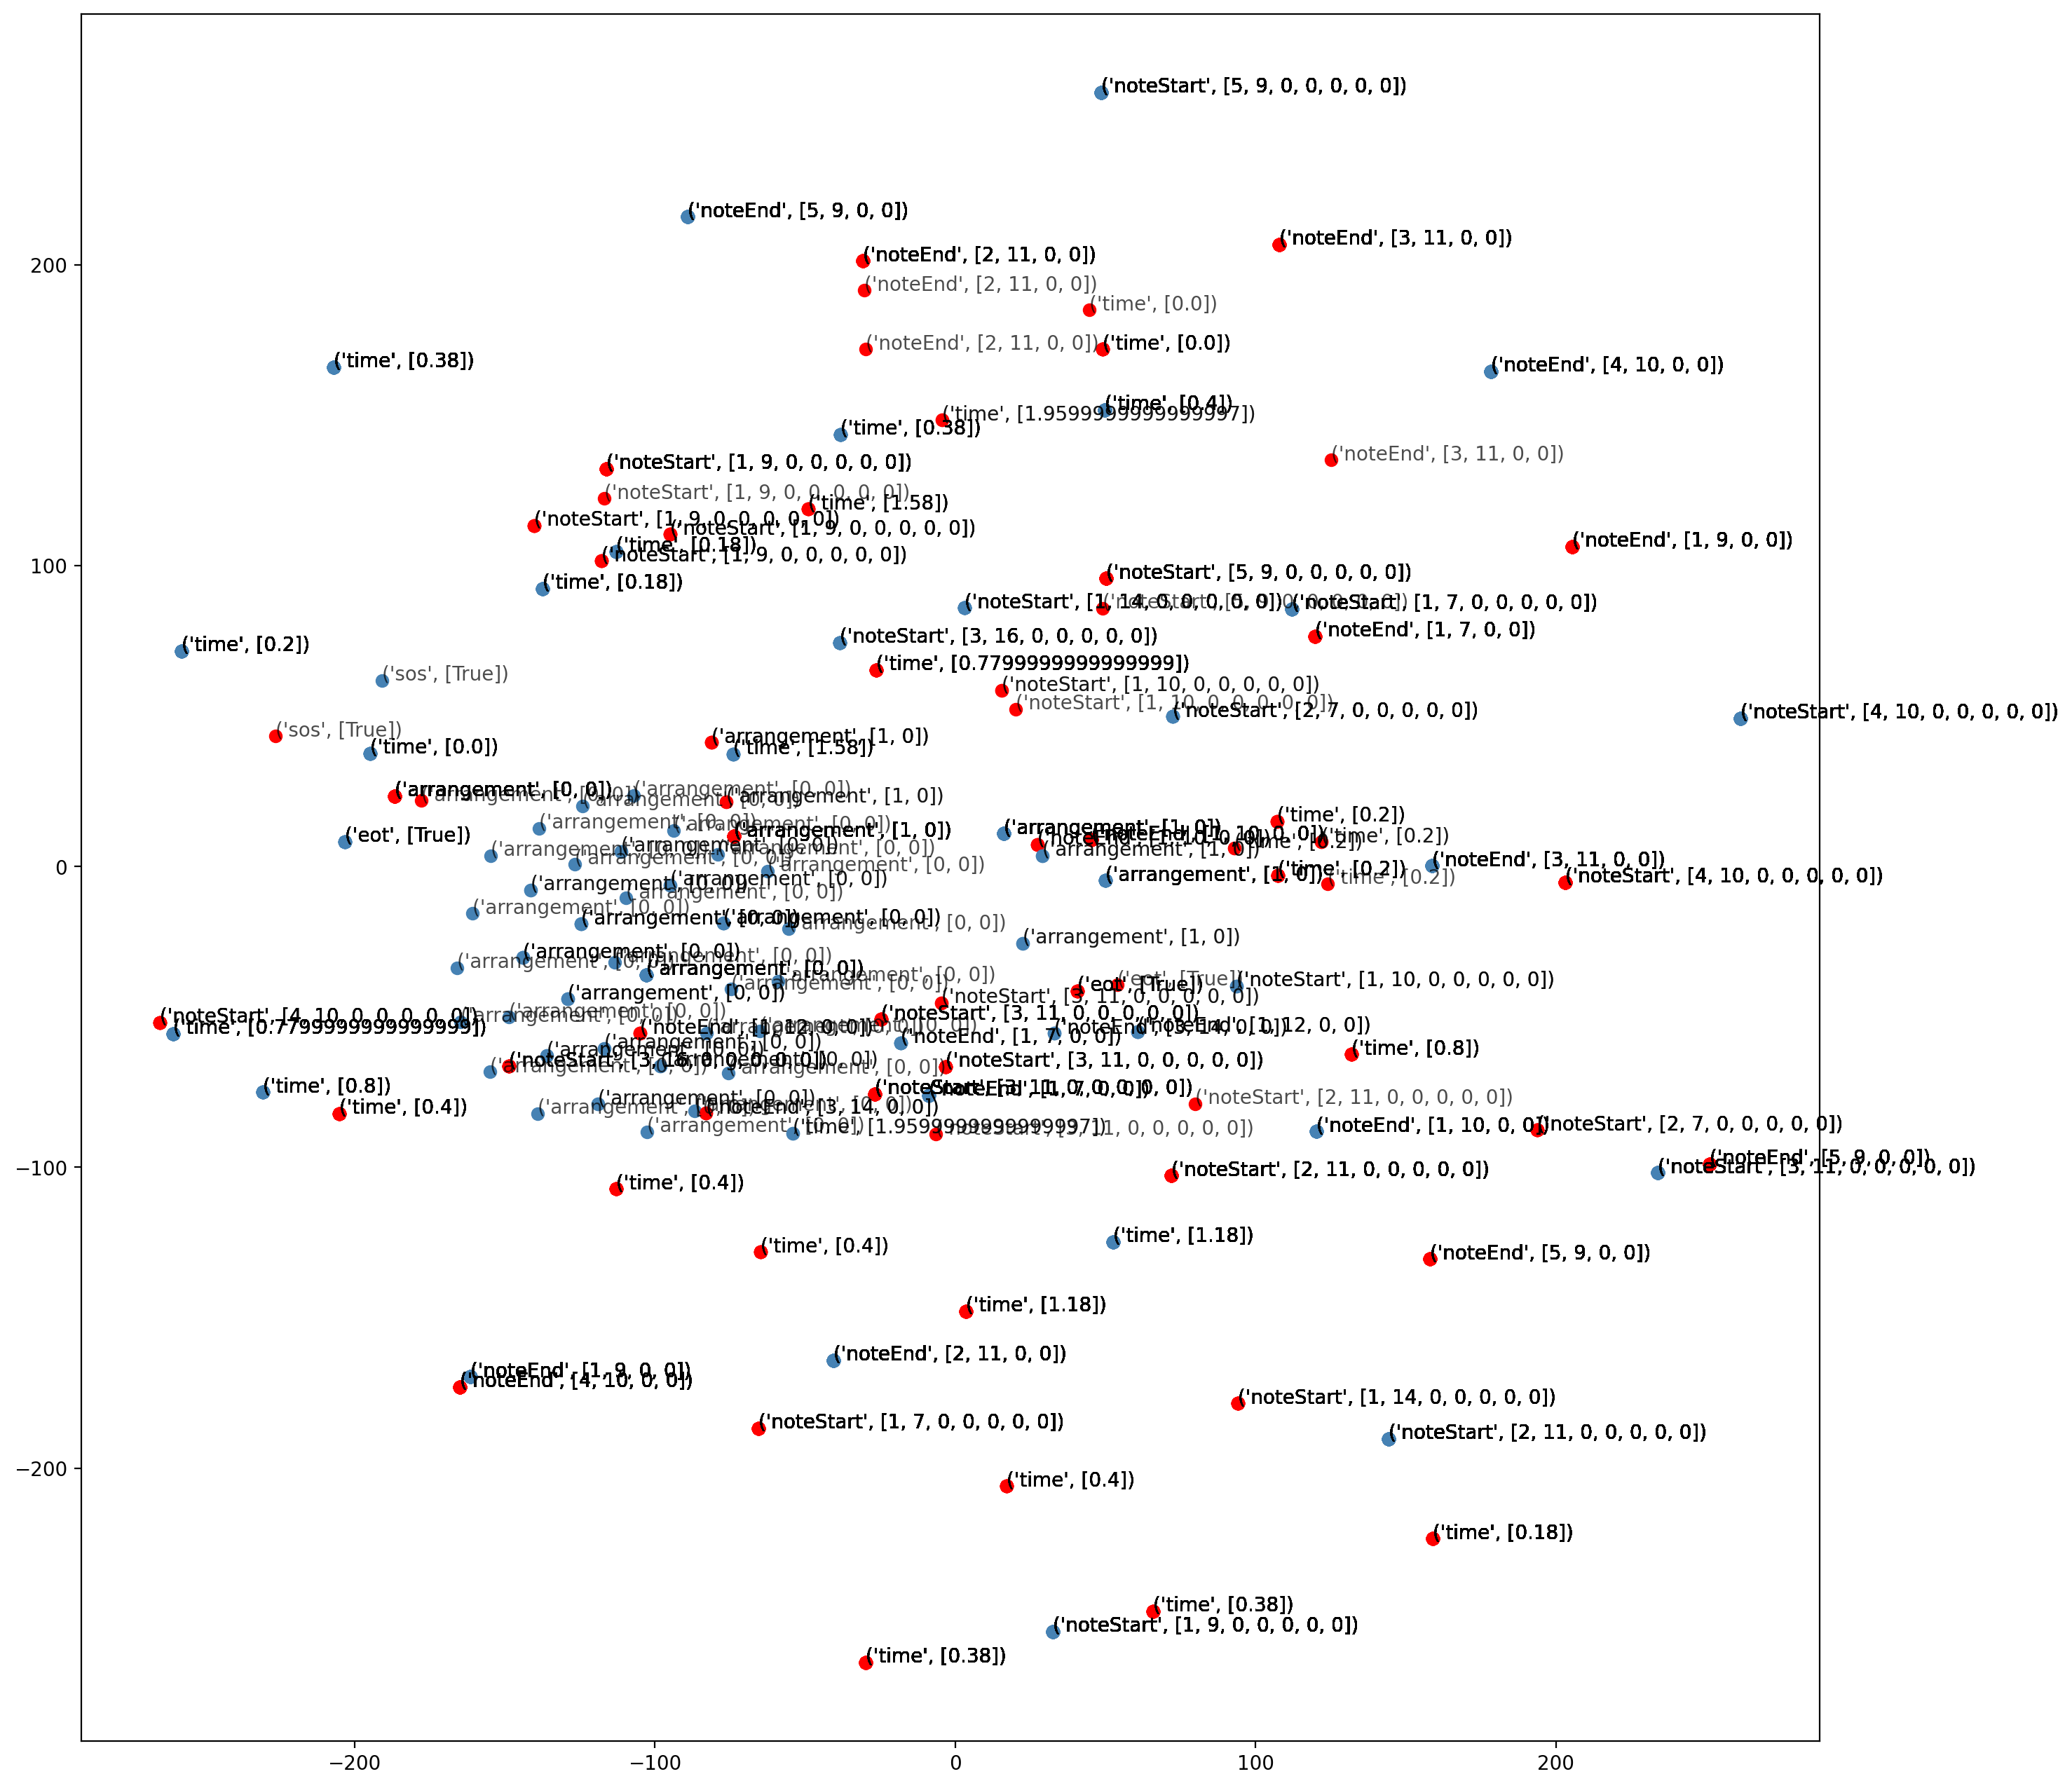

In [67]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(x[0].shape[0]):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.scatter(*embed_tsne_empty[idx, :], color='red')
    plt.annotate(str(tokenizer.encoder.decode(x[0][idx])), (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)
    plt.annotate(str(tokenizer.encoder.decode(x[0][idx])), (embed_tsne_empty[idx, 0], embed_tsne_empty[idx, 1]), alpha=0.7)